In [1]:
import pandas as pd
covid19World = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [ ]:
covid19SG = covid19World.loc[covid19World['location']=='Singapore']
covid19SG = covid19SG.loc[covid19SG['total_cases']>0]
covid19DailyCase = covid19SG.loc[:,['date','total_cases','new_cases']]

In [3]:
covid19SG = covid19SG.reset_index(drop=True)
covid19SG.describe()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,4.000000,0.0,4.000000,0.0
mean,2486.960784,178.480392,3.529412,0.176471,425.096618,30.507725,0.603304,0.030176,72449.000000,NaN,12.383750,NaN
std,4752.167595,337.284195,5.100390,0.454063,812.288663,57.651978,0.871785,0.077645,23408.223185,NaN,4.001066,NaN
min,3.000000,0.000000,0.000000,0.000000,0.513000,0.000000,0.000000,0.000000,47486.000000,NaN,8.117000,NaN
25%,78.000000,3.000000,0.000000,0.000000,13.332750,0.513000,0.000000,0.000000,56674.250000,NaN,9.687500,NaN
50%,207.000000,11.000000,0.000000,0.000000,35.382500,1.880000,0.000000,0.000000,71190.500000,NaN,12.168500,NaN
75%,1587.500000,120.750000,6.000000,0.000000,271.352000,20.640250,1.026000,0.000000,86965.250000,NaN,14.864750,NaN
max,18205.000000,1515.000000,18.000000,2.000000,3111.783000,258.959000,3.077000,0.342000,99929.000000,NaN,17.081000,NaN


In [4]:
covid19DailyCase['new_cases']= covid19DailyCase['new_cases'].astype(int)
covid19DailyCase['total_cases']= covid19DailyCase['total_cases'].astype(int)

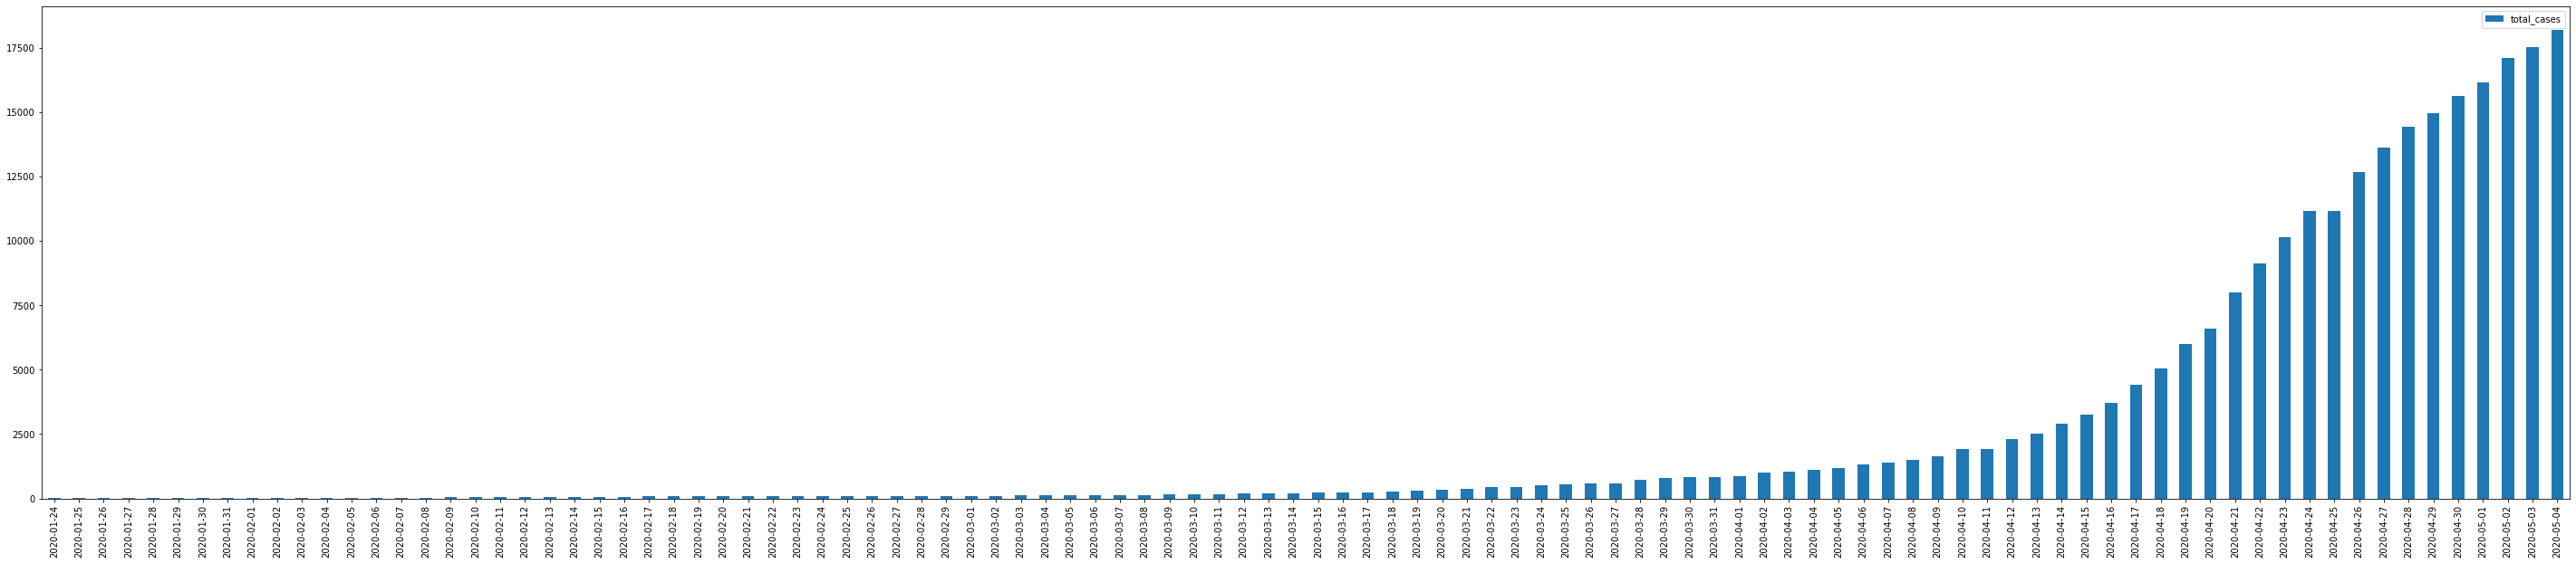

In [5]:
ax = covid19SG[['total_cases','date']].plot(kind='bar', figsize=(50,10))
ax.set_xticklabels(covid19SG['date']);

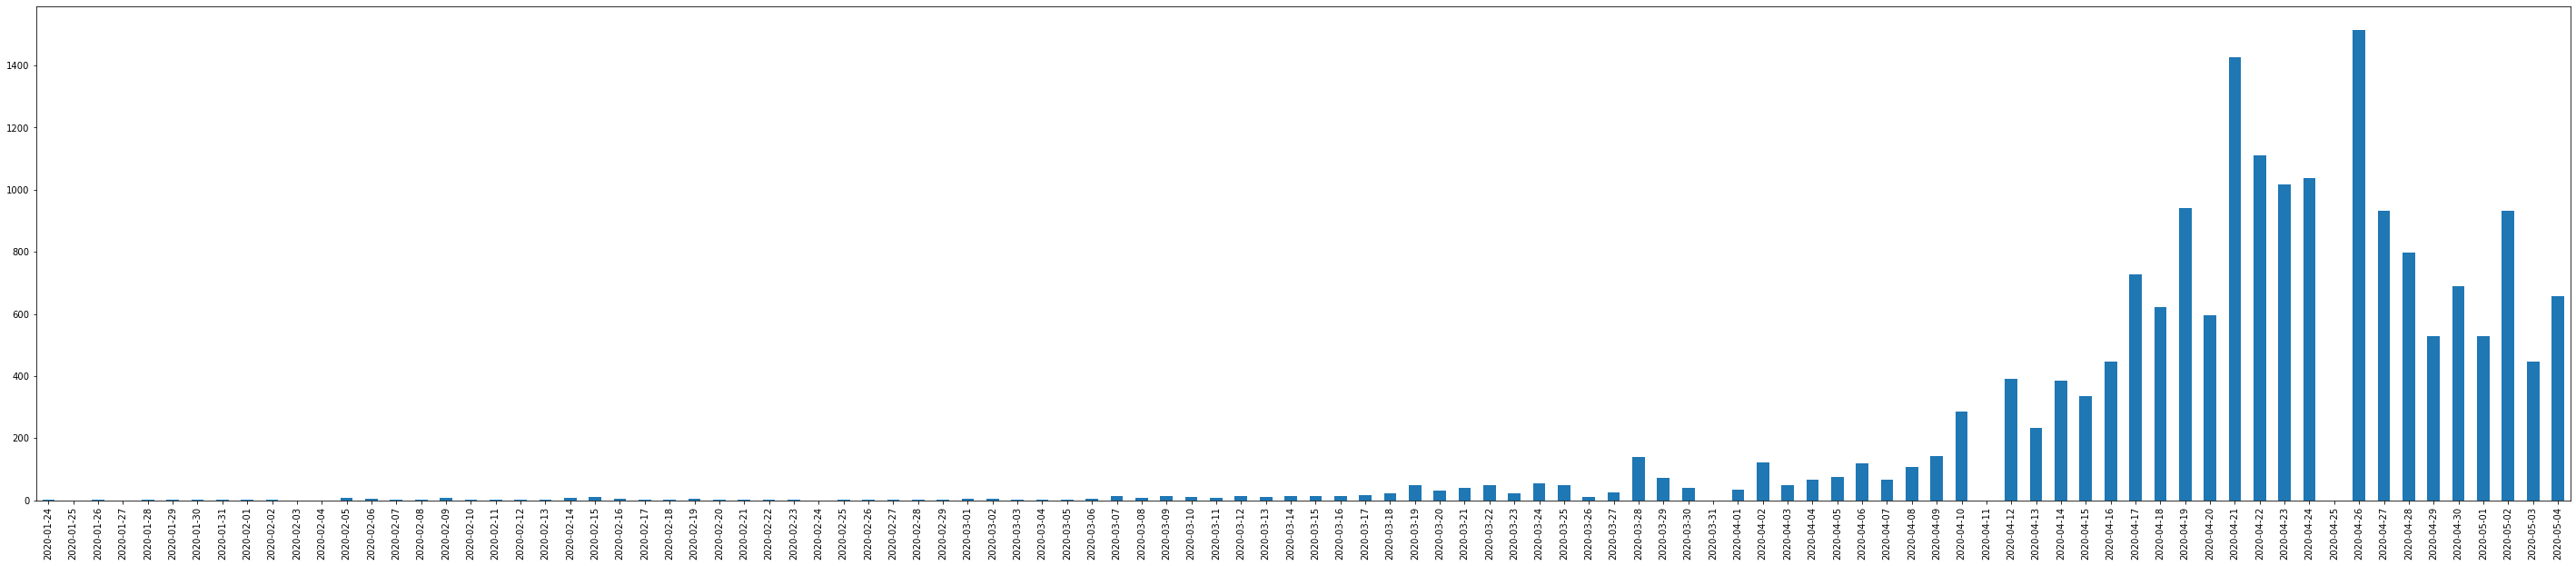

In [6]:
ax = covid19DailyCase['new_cases'].plot(kind='bar', figsize=(50,10))
ax.set_xticklabels(covid19SG['date']);

In [7]:
## We applied Population Growth Model
#  yi=β1/(1+exp(β2+β3xi))+ϵi
#  https://online.stat.psu.edu/stat501/lesson/15/15.8

In [8]:
# Solving initial condition

# From the graph, we noticed the peak increase at 22/April and 26/April
# Assume the peak growth is at 24/April (halfway point) 
# This values will be used as initial value for model fitting 
beta1 = 2 * covid19SG[covid19SG['date'] == '2020-04-22'].total_cases
beta1.values

# We use 24/Jan and 06/Apr value as two starting point to calculate inital beta2 and beta3 values
import numpy as np

#np.array([[1, covid19SG[covid19SG['date'] == '2020-01-24'].index], [1, covid19SG[covid19SG['date'] == '2020-04-06'].index]])
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-01-24'].total_cases - 1))
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-04-06'].total_cases - 1))
A = np.array([[1, 0], [1, 73]])
y = np.array([9.118773,2.635666])
beta2, beta3 = np.linalg.solve(A,y)
beta2, beta3


(9.118773, -0.08880968493150683)

In [9]:
y = beta1.values / (1 + np.exp(beta2 + beta3 * covid19SG.index.values))
beta1.values.astype(int), beta2, beta3

(array([18250]), 9.118773, -0.08880968493150683)

In [10]:
## To continue using Non-linear Least Squared Method
# https://en.wikipedia.org/wiki/Non-linear_least_squares

In [11]:
## Instead we use python library for curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def populationGrowthModel(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 + b3 * x))

xdata = covid19SG.index.values
ydata = covid19DailyCase['total_cases'].values

popt, pcov = curve_fit(populationGrowthModel, xdata, ydata, p0=[beta1.iloc[0], beta2, beta3])
popt, pcov

(array([ 2.18853989e+04,  1.54113096e+01, -1.68590802e-01]),
 array([[ 2.35157609e+05, -1.39367018e+02,  1.81238580e+00],
        [-1.39367018e+02,  1.20364559e-01, -1.48976029e-03],
        [ 1.81238580e+00, -1.48976029e-03,  1.85616608e-05]]))

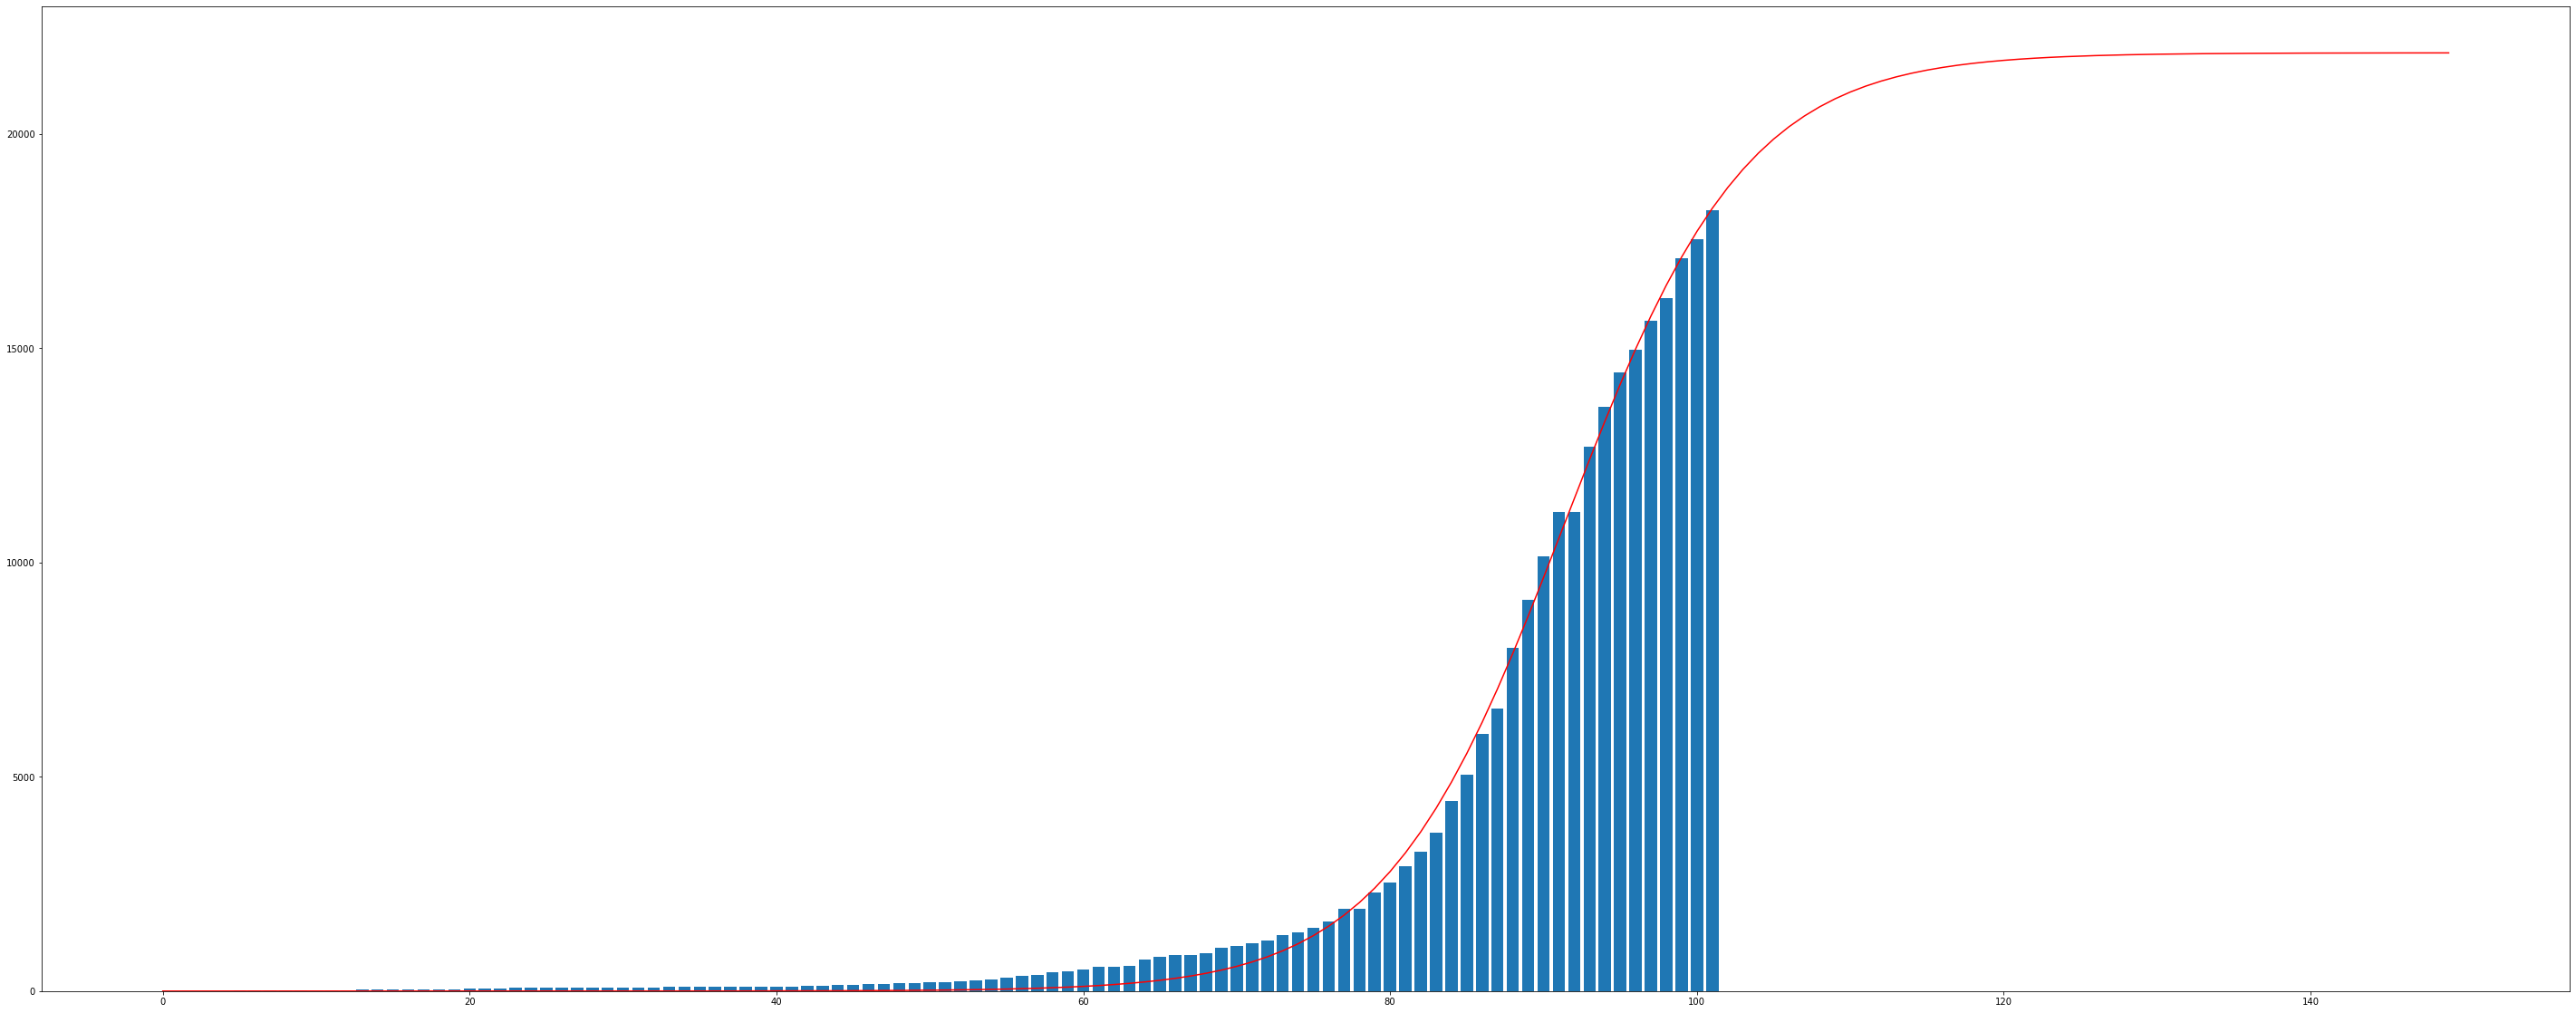

In [12]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))
plt.plot(estimationRage, populationGrowthModel(estimationRage, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.bar(estimationRage, np.pad(covid19SG['total_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()

In [16]:
## We enhance the estimation using Exponentially modified Gaussian distribution
# https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution
from scipy.stats import exponnorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def populationGrowthRateModel(x, a, loc, scale, K, d):
    return d * exponnorm.pdf(x, K, loc, scale)

xdata = covid19SG.index.values
yRateData = covid19DailyCase['new_cases'].values

popt, pcov = curve_fit(populationGrowthRateModel, xdata, yRateData)
popt, pcov

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1.00000000e+00, 8.39383887e+01, 4.73103212e+00, 3.07513594e+00,
        2.44291186e+04]),
 array([[inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf]]))

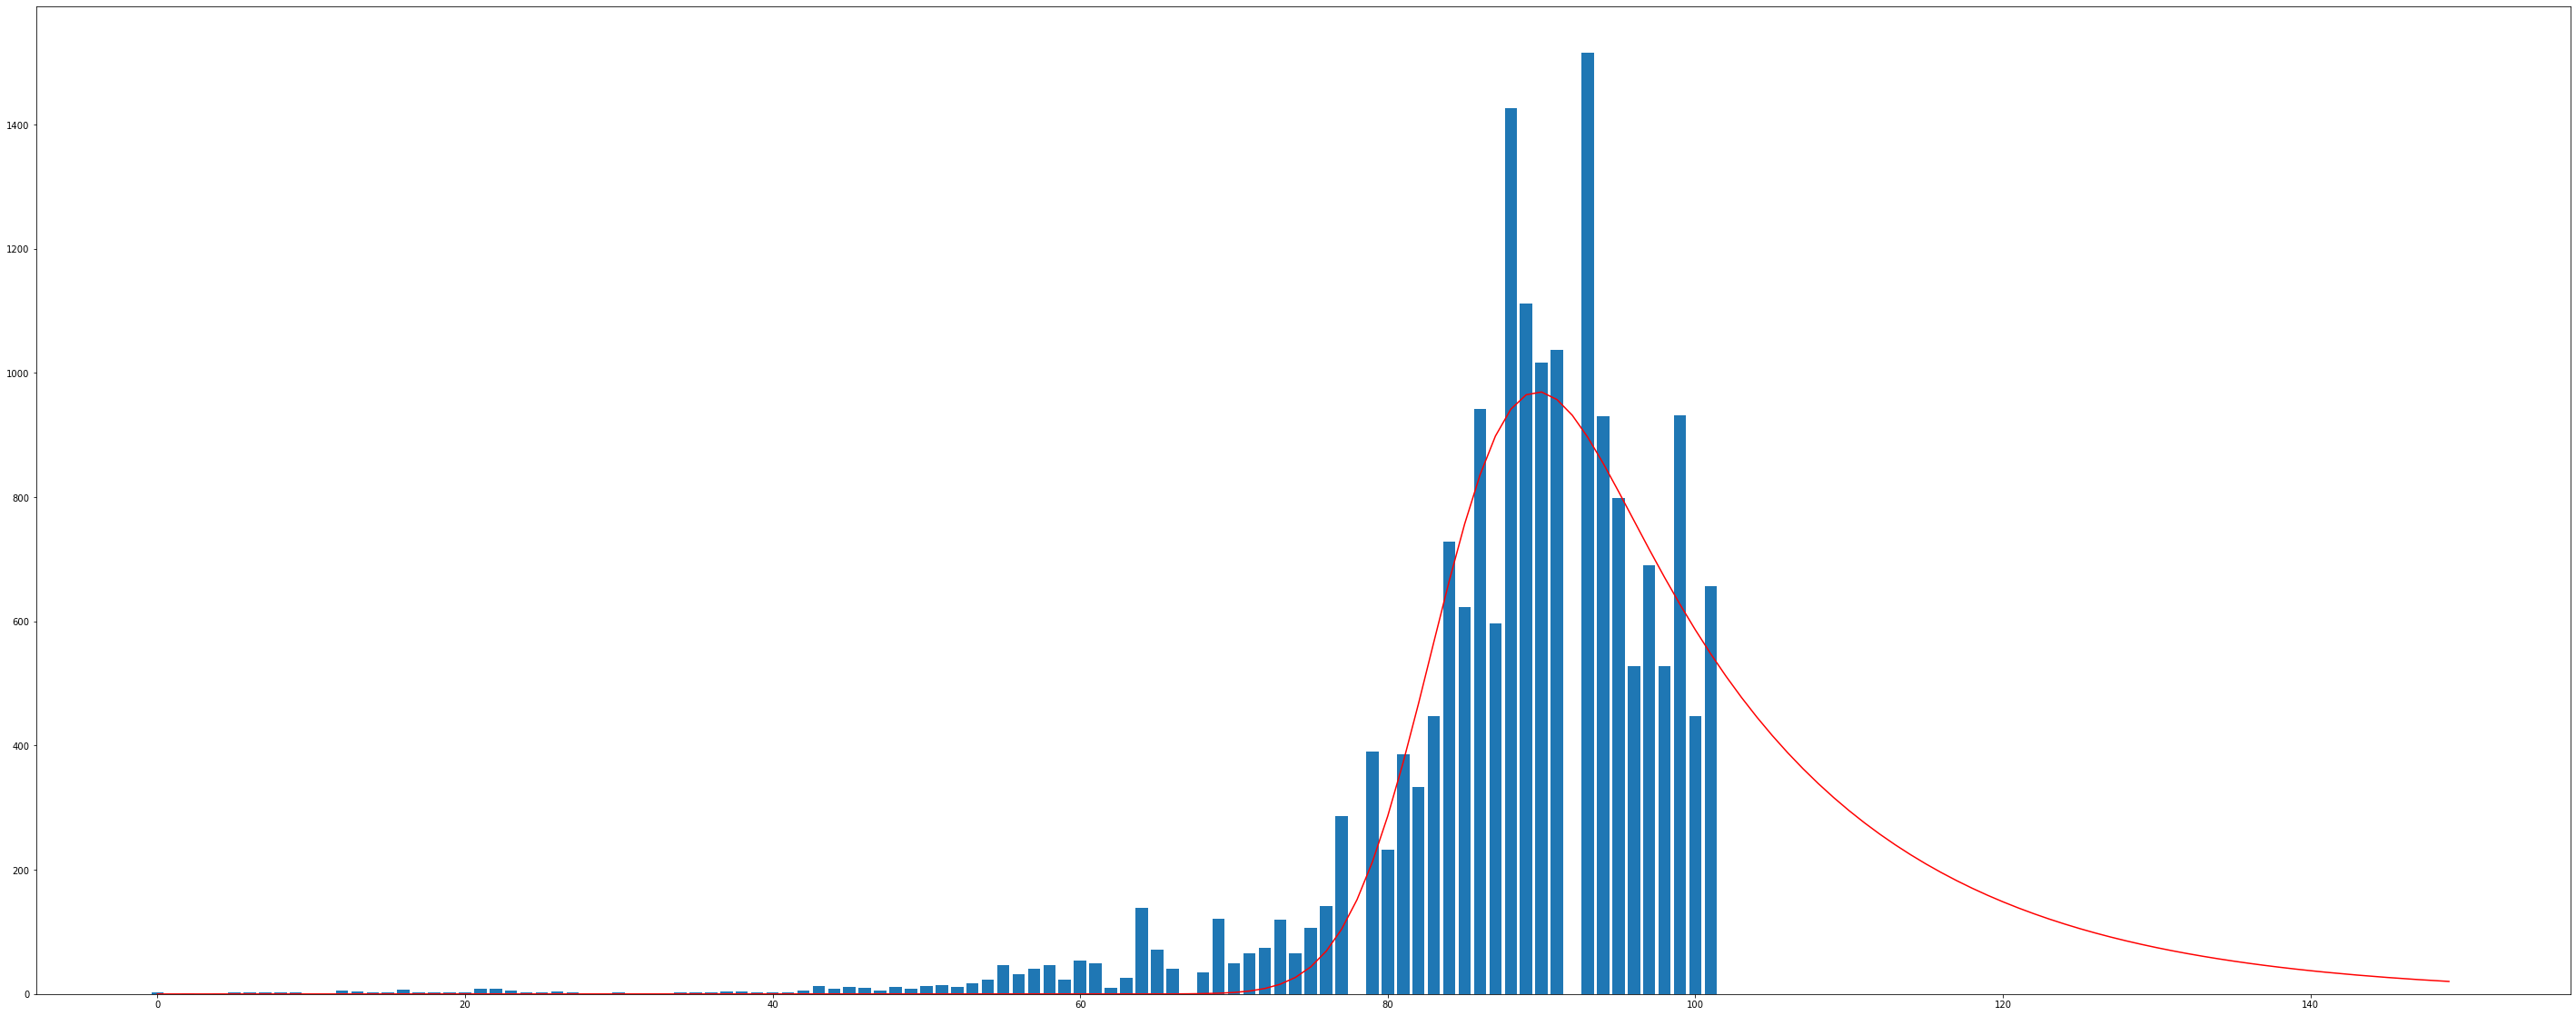

In [17]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))
plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *popt), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['new_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()

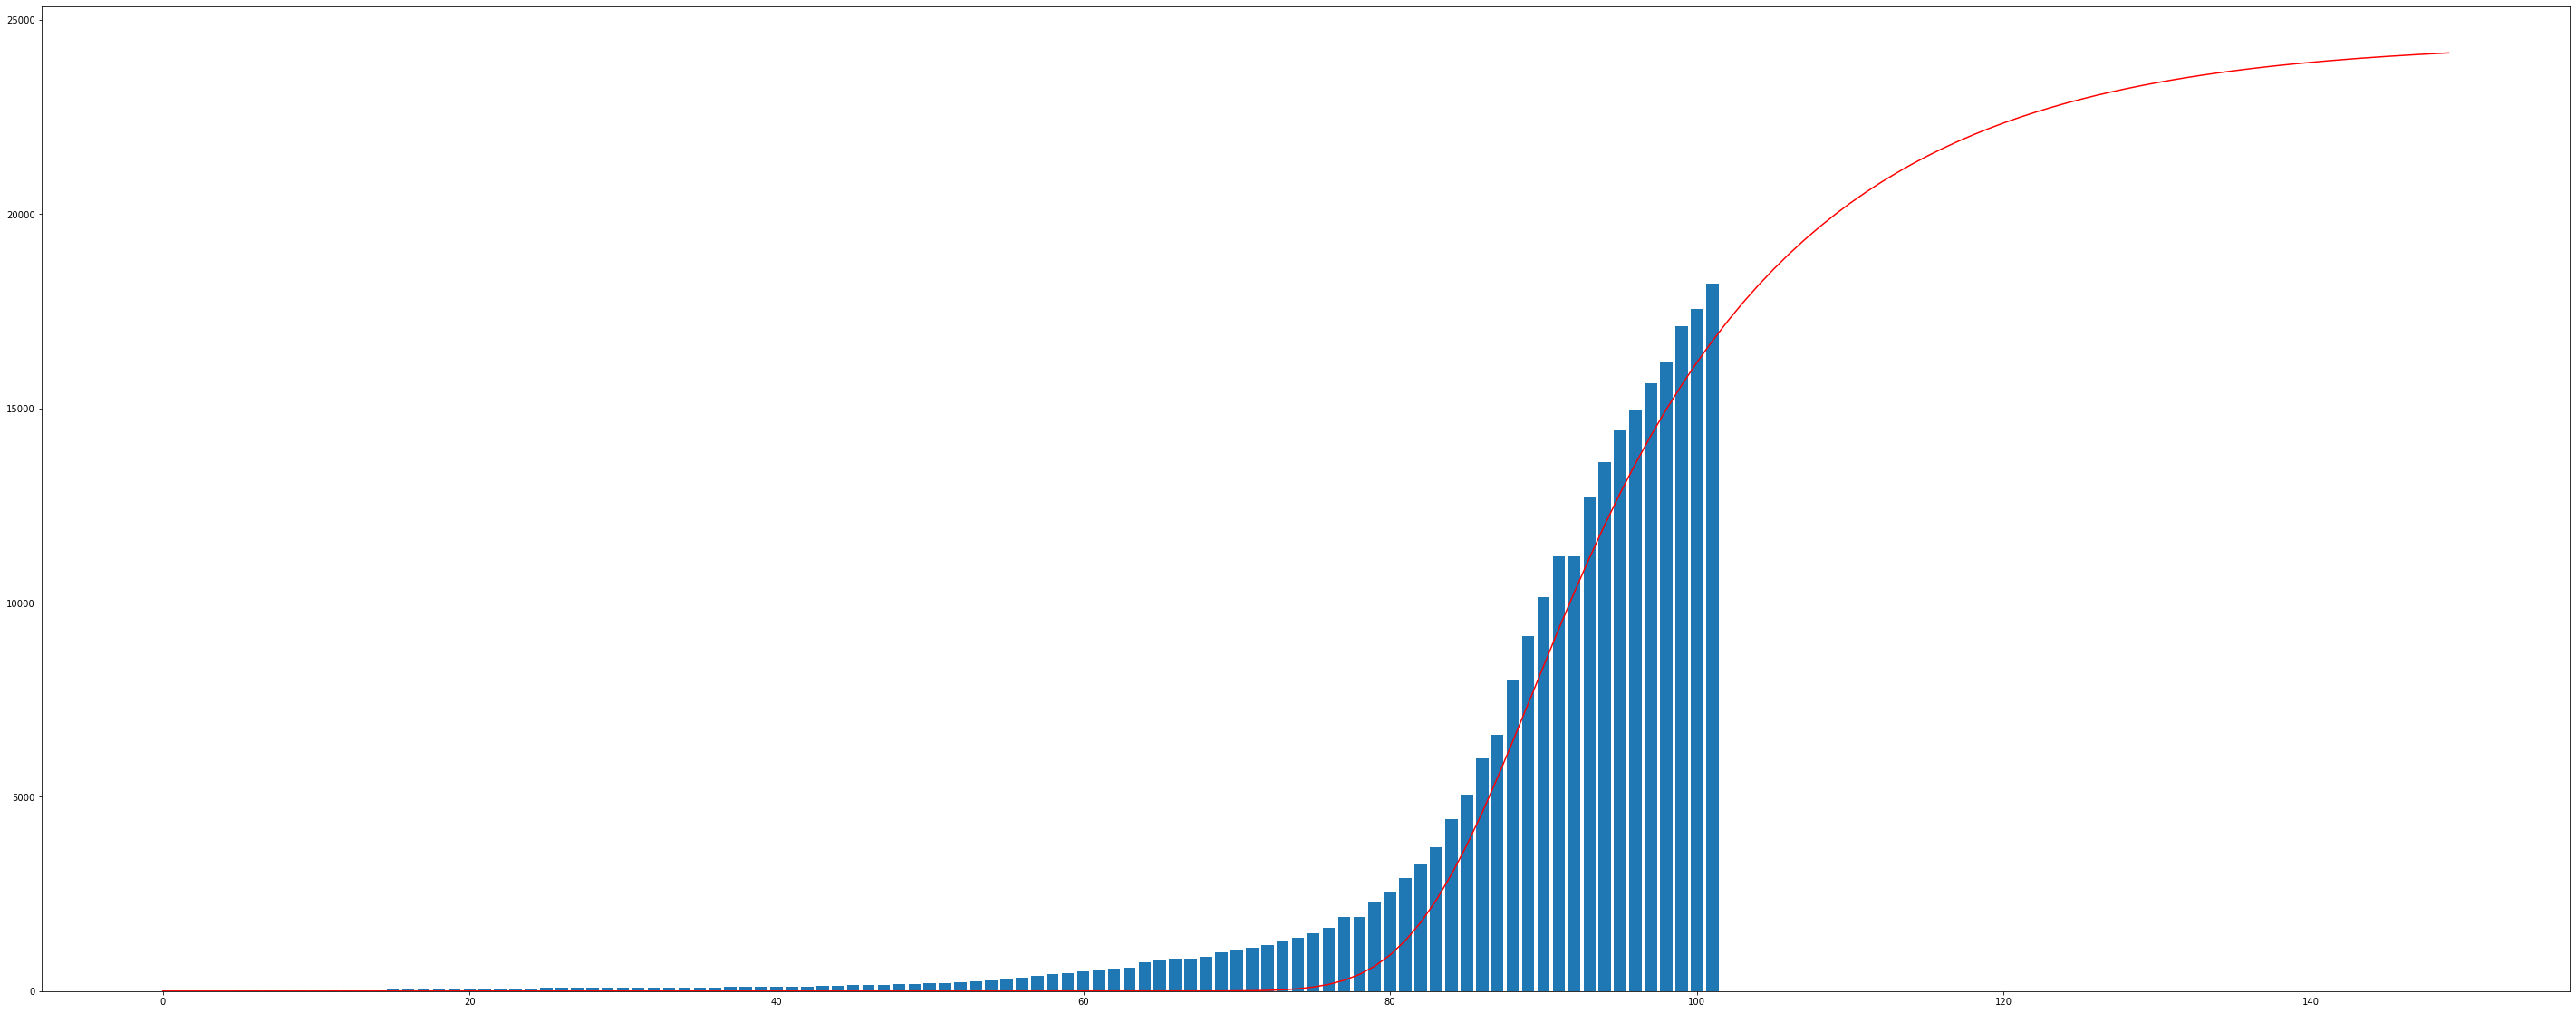

In [15]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))
plt.plot(estimationRage, populationGrowthRateModel(range(0,150), *popt).cumsum(), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['total_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()